# 使用块的网络（VGG）

<https://courses.d2l.ai/zh-v2/assets/notebooks/chapter_convolutional-modern/vgg.slides.html#/>

## 定义VGG块

In [1]:
import torch
from torch import nn
import d2l_torch as d2l

In [33]:
def vgg_block(num_convs,in_channels,out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        )
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

+ 这里`in_channels=out_channels`，比如in=1，out=5，那么就会产生，conv2d(1,5),conv2d(5,5),conv2d(5,5)这样的结果
+ 想想alexnet中，conv2d(256,384),conv2d(384,384)这部分。

In [12]:
test_dict={"wangwu":12,"zhaosi":8}

{**{"wangwu":12,"zhaosi":8}}

{'wangwu': 12, 'zhaosi': 8}

In [11]:
{'x': 1, **{'y': 2}}

{'x': 1, 'y': 2}

这里给出一个卷积的组合架构，就是5个VGG块，
+ 可以看到，这个结构其实就是之前说的:`长宽减半，通道数翻倍`
+ 另外，为什么是5块，其实是因为224/2^5=7，除到这里除不动了，所以刚好就是5块，卷积层长宽减半5次。
+ 只需要卷积层的个数（多少层卷积层，n），每个卷积层的输入输出通道，VGG_block需要的参数
+ 不需要知道输入输出tensor的维度，需要的话，就自己算或者打印一下看看

In [14]:
224/2**5

7.0

这其实是VGG11的结构

In [16]:
conv_arch=((1,64),(1,128),(2,256),(2,512),(2,512))
# 表示输出通道64、128的卷积层各1个
# 输出通道256/512/521的卷积层各两个
# 一共5个VGG块

In [24]:
def vgg(conv_arch):
    conv_blks=[]
    in_channels=1  # 其实这个可以写成一个形参
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels=out_channels    
    return nn.Sequential(
        *conv_blks,nn.Flatten(),
        nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(p=0.5),
        nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(p=0.5),
        nn.Linear(4096,10))

In [25]:
net=vgg(conv_arch)

In [28]:
X=torch.randn((1,1,224,224))
for layer in net:
    X=layer(X)
    print(f"{layer.__class__.__name__}——output shape:\t {X.shape}")

Sequential——output shape:	 torch.Size([1, 64, 112, 112])
Sequential——output shape:	 torch.Size([1, 128, 56, 56])
Sequential——output shape:	 torch.Size([1, 256, 28, 28])
Sequential——output shape:	 torch.Size([1, 512, 14, 14])
Sequential——output shape:	 torch.Size([1, 512, 7, 7])
Flatten——output shape:	 torch.Size([1, 25088])
Linear——output shape:	 torch.Size([1, 4096])
ReLU——output shape:	 torch.Size([1, 4096])
Dropout——output shape:	 torch.Size([1, 4096])
Linear——output shape:	 torch.Size([1, 4096])
ReLU——output shape:	 torch.Size([1, 4096])
Dropout——output shape:	 torch.Size([1, 4096])
Linear——output shape:	 torch.Size([1, 10])


可以看到，这里输出的不再是一层一层的，
+ 比如：conv2d输出多少，relu输出多少，maxpool输出多少
+ 输出是以VGG块作为基本单位了，前五层的Sequential输出
+ 所以这其实是因为定义的时候包了一层，如果想要得到这个前五个VGG块/Sequential里的东西，应该也可以输出

这样其实看起来反而更方便，看一块的输出，其实好计算。
+ 很明显就可以看出来，这五个VGG块输出的维度，刚好就是224减半，112，再减半，56……，同时通道数从64翻倍翻倍变成了512，其实第五个VGG Block可以是1024的，也没关系，但是VGG11没有这么做，所以就按照人家试验过的来咯

> **长宽减半，通道数翻倍，是之后经常会看到的卷积神经网络的一个设计模式！**

In [32]:
X=torch.randn((1,1,224,224))
for vgg_blocks in net[:5]:
    for layer in vgg_blocks:
        X=layer(X)
        print(f"{layer.__class__.__name__}——output shape:\t {X.shape}")

Conv2d——output shape:	 torch.Size([1, 64, 224, 224])
ReLU——output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d——output shape:	 torch.Size([1, 64, 112, 112])
Conv2d——output shape:	 torch.Size([1, 128, 112, 112])
ReLU——output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d——output shape:	 torch.Size([1, 128, 56, 56])
Conv2d——output shape:	 torch.Size([1, 256, 56, 56])
ReLU——output shape:	 torch.Size([1, 256, 56, 56])
Conv2d——output shape:	 torch.Size([1, 256, 56, 56])
ReLU——output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d——output shape:	 torch.Size([1, 256, 28, 28])
Conv2d——output shape:	 torch.Size([1, 512, 28, 28])
ReLU——output shape:	 torch.Size([1, 512, 28, 28])
Conv2d——output shape:	 torch.Size([1, 512, 28, 28])
ReLU——output shape:	 torch.Size([1, 512, 28, 28])
MaxPool2d——output shape:	 torch.Size([1, 512, 14, 14])
Conv2d——output shape:	 torch.Size([1, 512, 14, 14])
ReLU——output shape:	 torch.Size([1, 512, 14, 14])
Conv2d——output shape:	 torch.Size([1, 512, 14, 14])
ReLU——o

如果闲的没事干，非要看看这里面的块，也可以再递归进去一层，然后打印一下看看。其实和conv_arch中规定的结构是一模一样的。。。

另外，由于VGG比AlexNet计算量大很多，为了方便训练，简化一下，弄了一个通道数比较少的网络

In [34]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# 每个VGG块有几层卷积层的个数不变，输出通道大小整除以4（只要商，不要余数）

# 然后重新构建训练用的网络
net = vgg(small_conv_arch)

**注意：**
> 报了一个很无语的错误，因为上面打印每个VGG_Block的时候，使用了一个和vgg_block()函数同名的变量，vgg_block,所以执行上面vgg(small_conv_arch)的时候报错，说只接受两个参数，但是给了四个。。。。
> 因为python支持函数化编程，所以变量名可以充作函数名，是便利，但也是个隐患

下面是最后的训练结果，

loss 0.096, train acc 0.965, test acc 0.933
281.4 examples/sec on cuda:0


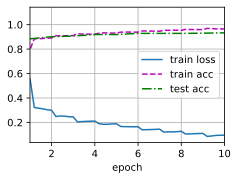

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

torch.cuda.empty_cache()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

+ 我的batch_size是32，训练下来效果倒是比沐神的好

沐神的
```bash
loss 0.172, train acc 0.936, test acc 0.923
1796.4 examples/sec on gpu(0)
```

我的
```bash
loss 0.096, train acc 0.965, test acc 0.933
281.4 examples/sec on cuda:0
```

+ 很费GPU显存，参数量也大，但是通道数已经降低了4倍了。。。
+ 但是精度依然很高，真的真的高，虽然有点过拟合，但是不影响高啊
+ 从LeNet到AlexNet，再到VGG，越来越高。。。